In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
%matplotlib inline

np.random.seed(4)

## P1: Importance Sampling

In [14]:
def importance_sampling(x):
    weights = uniform.pdf(x, 0.0, 4.0) / norm.pdf(x, 0.0, 1.0)
    return weights

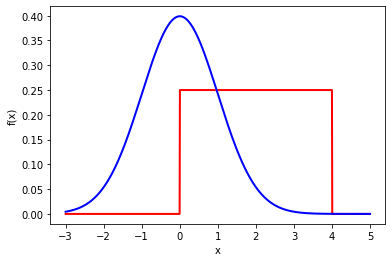

In [3]:
x = np.linspace(-3.0, 5.0, 1000)
plt.plot(x, uniform.pdf(x, 0.0, 4.0), linewidth=2, color='r')
plt.plot(x, norm.pdf(x, 0.0, 1.0), linewidth=2, color='b')
plt.xlabel('x'); plt.ylabel('f(x)')
plt.show()
# Probably not valid since N(0, 1) is almost zero over the target dist U(0, 4)

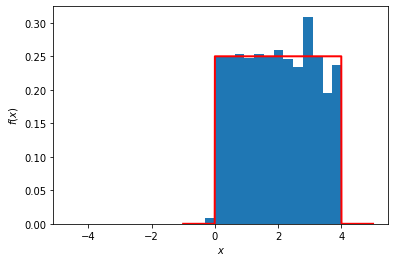

In [50]:
N = 100000
x = np.random.normal(0.0, 1.0, N)
w = importance_sampling(x)
count, bins, _ = plt.hist(x, bins=30, density=True, weights=w)
array = np.linspace(-1.0, 5.0, 1000)
plt.plot(array, uniform.pdf(array, 0.0, 4.0), linewidth=2, color='r')
plt.xlabel('$x$'); plt.ylabel('$f(x)$')
plt.show()
# Pretty good approximation of the target 
#Moving the mean seems to make it worse 

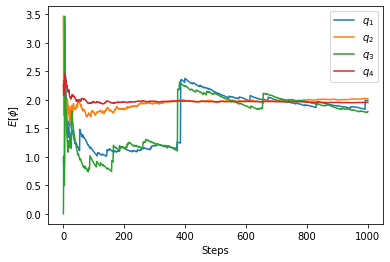

In [49]:
M = 1000
N = 10
Mu = [0.0, 2.0, 6.0, 2.0 ]
Sigma = [1.0, 10.0, 1.0, 1.0]

for i in range(len(Mu)):
    mu = Mu[i]
    sigma = Sigma[i]
    phi = []
    phi_means = []
    for j in range(M):
        
        # Importance sampling
        x = np.random.normal(mu, sigma, N)
        w = uniform.pdf(x, 0.0, 4.0) / norm.pdf(x, mu, sigma)
        #w = w / np.sum(w)

        # MC estimate of mean of identity function
        phi_hat = np.sum(x * w) / N
        phi.append(phi_hat)
        phi_means.append(np.mean(phi))

    array = np.linspace(1, M, M)
    plt.plot(array, phi_means, label='$q_' + str(i+1) + '$')
plt.legend(loc='upper right')
plt.xlabel('Steps'); plt.ylabel('$E[\phi]$')
plt.show()

Informal derivation of the estimator of the normalizing constant $Z$:

$Z = \int \tilde{\pi}(x) \,dx = \int \frac{\tilde{\pi}(x)}{q(x)} q(x) \,dx = \int \tilde{w} q(x) \, dx = E[\tilde{w}] \approx \frac{1}{N} \sum_{i=1}^{N} \tilde{w}^i$

C:\Users\Marcus\Miniconda3\envs\smc\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


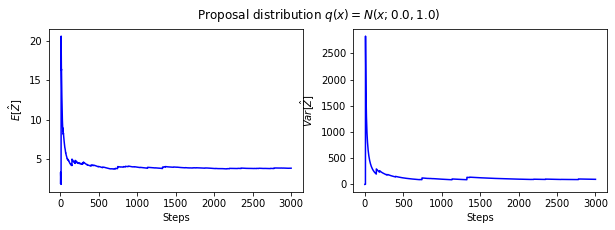

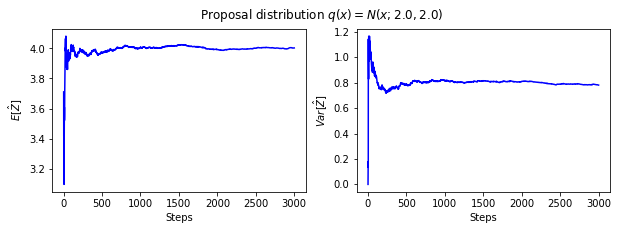

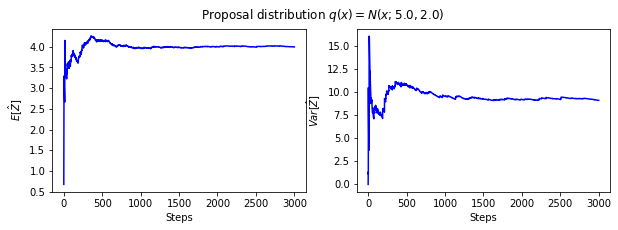

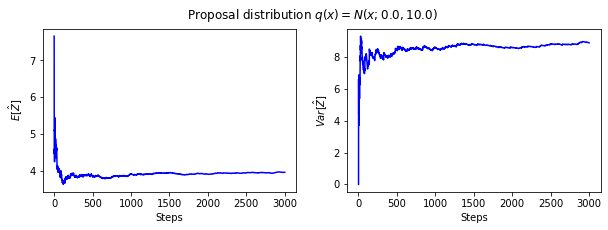

In [111]:
def indicator_function(x, min=0.0, max=4.0):
    ind = np.array((x >= min) & (x <= max)).astype(np.float32)
    return ind

def gaussian_pdf(x, mu=0.0, scale=1.0):
    return 1/np.sqrt(2 * np.pi * sigma**2) * np.exp(-0.5*((x-mu)/sigma)**2)

M = 3000
N = 10
Mu = [0.0, 2.0, 5.0, 0.0]
Sigma = [1.0, 2.0, 2.0, 10.0]
Z_hat = np.zeros([len(Mu), M])
for k, (mu, sigma) in enumerate(zip(Mu, Sigma)):
    #for i in range(n_runs):
    z_hat = []
    Z_hat = np.zeros(M)
    var_Z_hat = np.zeros(M)
    for m in range(M):

        x = np.random.normal(loc=mu, scale=sigma, size=N)
        w_tilde = indicator_function(x) / gaussian_pdf(x, mu, sigma)
        w = w_tilde / np.sum(w_tilde)
        z_hat.append(np.mean(w_tilde))
        Z_hat[m] = np.mean(z_hat)
        var_Z_hat[m] = np.var(z_hat)
        
    
    #fig, ax = plt.subplots(nrows=1, ncols=2)
    fig = plt.figure(figsize=(10,3))
    fig.suptitle('Proposal distribution $q(x) = N(x; %.1f, %.1f)$' %(mu, sigma))
    plt.subplot(121)
    plt.plot(np.linspace(1, M, M), Z_hat, color='b', label="$q_%s$" %(k+1))
    plt.xlabel('Steps'); plt.ylabel('$E[\hat{Z}]$'); 
    plt.subplot(122)
    plt.plot(np.linspace(1, M, M), var_Z_hat, color='b', label="$q_%s$" %(k+1))
    plt.xlabel('Steps'); plt.ylabel('$Var[\hat{Z}]$');
    plt.show()


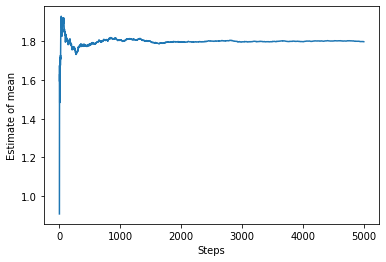

In [131]:
np.random.seed(4)
M = 5000
N = 10
eps = 1e-8 # For numerical stability, sometimes all w_tilde = 0 due to indicator function
mu = 0.0
sigma = 2.0
estimates = []
pi_means = np.zeros(M)
for m in range(M):
    x = np.random.normal(loc=mu, scale=sigma, size=N)
    w_tilde = indicator_function(x) / gaussian_pdf(x, mu, sigma) + eps
    w = w_tilde / np.sum(w_tilde)
    Z_hat = np.mean(w_tilde)
    pi_mean = 1/(N * Z_hat) * np.sum(x * w_tilde)
    estimates.append(pi_mean)
    pi_means[m] = np.mean(estimates)
plt.plot(np.linspace(1, M, M), pi_means)
plt.xlabel('Steps'); plt.ylabel('Estimate of mean'); 
plt.show()

## P2: Importance sampling in higher dimensions

In [216]:
from scipy.stats import multivariate_normal
def importance_sampling(N, D):
    mu = np.zeros(D)
    Sigma = np.identity(D)
    
    if D > 1:
        x = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)
        qx = multivariate_normal.pdf(x, mean=mu, cov=Sigma)
        px = np.prod(uniform.pdf(x, loc=[-0.5] * D, scale=[1.0] * D), axis=1)
    else:
        x = np.random.normal(loc=0.0, scale=1.0, size=N)
        qx = norm.pdf(x, loc=0.0, scale=1.0)
        px = uniform.pdf(x, loc=-0.5, scale=1.0)
    w = px / qx
    return x, w

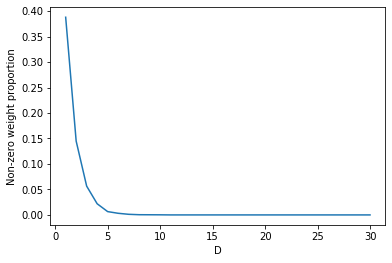

In [225]:
D = 30
N = 10000
w_proportion = np.zeros(D)
for d in range(1, D+1):
    x, w = importance_sampling(N, d)
    w_proportion[d-1] = np.sum(w > 0.0) / N
plt.plot(np.linspace(1, D, D), w_proportion)
plt.xlabel('D'); plt.ylabel("Non-zero weight proportion");
plt.show()
# As the dimension increases, the discrepancy between the proposal and target distributions will decrease
# Thus the variance of the importance weights will increase

## P3: An important numerical aspect

In [249]:
from scipy.stats import multivariate_normal
def importance_sampling(N, D):
    mu = np.zeros(D)
    Sigma = 2**2 * np.identity(D)
    
    if D > 1:
        x = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)
        #qx = multivariate_normal.pdf(x, mean=mu, cov=Sigma)
        #px_tilde = np.prod(norm.pdf(x, loc=0.0, scale=1.0), axis=1)
        log_qx = multivariate_normal.logpdf(x, mean=mu, cov=Sigma)
        log_px_tilde = np.sum(norm.logpdf(x, loc=0.0, scale=1.0), axis=1) 
    else:
        x = np.random.normal(loc=0.0, scale=2.0, size=N)
        qx = norm.pdf(x, loc=0.0, scale=2.0)
        px_tilde = norm.pdf(x, loc=-0.5, scale=1.0)
    #w_tilde = px_tilde / qx
    #w = w_tilde / np.sum(w_tilde)
    log_w_tilde = log_px_tilde - log_qx
    #w = np.exp(log_w_tilde) / np.sum(np.exp(log_w_tilde))
    w_bar = logsumexp(log_w_tilde)
    w = w_bar / np.sum(w_bar)
    return x, w#, w_tilde

def logsumexp(log_x):
    max_log_x = np.max(log_x)
    return np.exp(log_x - max_log_x)

In [245]:
# With pdf
np.random.seed(1)
D = 30
N = 10
x, w, w_tilde = importance_sampling(N, D)
print("Normalized weights: ", w)
# All but one or two weights are almost equal to zero
# Curse of dimensionality

Normalized weights:  [1.28998279e-09 3.17742798e-03 2.73195700e-05 4.86996184e-01
 2.60546965e-05 3.26573575e-12 3.18593551e-12 6.57378193e-11
 8.77473683e-11 5.09773012e-01]


In [243]:
# With logpdf
np.random.seed(1)
D = 30
N = 10
x, w, w_tilde = importance_sampling(N, D)
print("Normalized weights: ", w)
# Still the same values

Normalized weights:  [1.28998279e-09 3.17742798e-03 2.73195700e-05 4.86996184e-01
 2.60546965e-05 3.26573575e-12 3.18593551e-12 6.57378193e-11
 8.77473683e-11 5.09773012e-01]


In [250]:
# With logsumexp trick
np.random.seed(1)
D = 30
N = 10
x, w = importance_sampling(N, D)
print("Normalized weights: ", w)
# Same values still, but should be used anyway for numerical stability reasons in Monte Carlo 

Normalized weights:  [1.28998279e-09 3.17742798e-03 2.73195700e-05 4.86996184e-01
 2.60546965e-05 3.26573575e-12 3.18593551e-12 6.57378193e-11
 8.77473683e-11 5.09773012e-01]


## P4: Bootstrap particle filter for the stochastic volatility model

In [5]:
# Import data
import os
path = os.getcwd()
y = np.genfromtxt(path + '/seOMXlogreturns2012to2014.csv')

# Static parameters
phi = 0.98
sigma = 0.16
beta = 0.7

def bootstrap_particle_filter(y, n_particles):
    T = len(y)
    x = np.random.normal(0.0, 1.0, size=n_particles)
    w = np.ones(n_particles) / n_particles
    w_tilde = np.zeros(n_particles)
    
    X = np.zeros([T+1, n_particles])
    X[0, :] = x
    W = np.zeros([T+1, n_particles])
    W[0, :] = w
    for t in range(1, T+1):
        
        a = np.random.choice(n_particles, n_particles, p=w)
        x = np.random.normal(loc=phi*x[a], scale=sigma)
        log_w_tilde = norm.logpdf(y[t-1], loc=0.0, scale=np.sqrt(beta**2 * np.exp(x)))
                                  
        # Normalize with log trick
        w_bar = np.exp(log_w_tilde - np.max(log_w_tilde))
        w = w_bar / np.sum(w_bar)
        
        X[t, :] = x
        W[t, :] = w
    return X, W

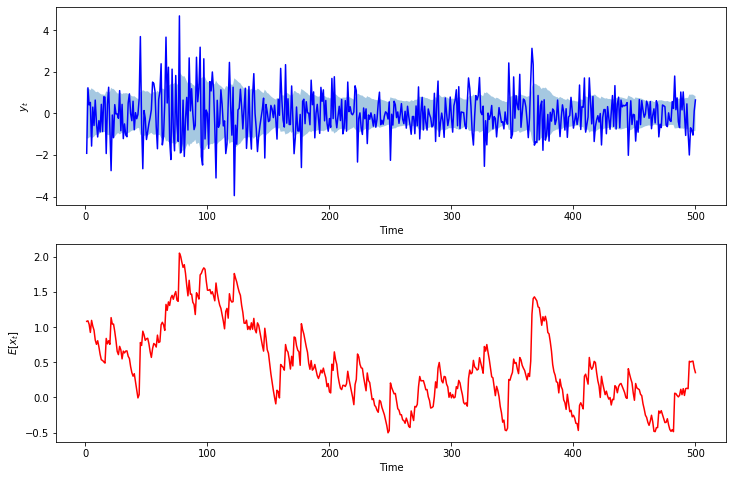

In [6]:
N = 200 # number of particles
T = len(y)
#n_runs = 5
#px_given_y = np.zeros([n_runs, N])
#for i in range(n_runs):
#px_given_y[i, :] = np.sum(w[1:, :], axis=1)
x, w = bootstrap_particle_filter(y, N)
means = np.sum(w[1:, :] * x[1:, :], axis=1)
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(np.linspace(1, T, T), y, color='b')
ax[0].fill_between(np.linspace(1, T, T), y1=-beta*np.exp(means / 2), y2=beta*np.exp(means / 2), alpha=0.4)
ax[0].set_xlabel("Time"); ax[0].set_ylabel("$y_t$")

ax[1].plot(np.linspace(1, T, T), means, color='r')
ax[1].set_xlabel("Time"); ax[1].set_ylabel("$E[x_t]$")
plt.show()
# Plot the mean of the filtering distribution p(x_t, y_{1:t}), think about it